# Asteroid Class Prediction Leveraging Parallelization Techniques 

<div style="text-align: right">  
<strong>Uday Kiran Dasari</strong>
</div>
<br/>
<center>
<img src="Asteroid.jpg" width=700 />
</center>
<br/>

**Link to Dataset used**: [**Asteroid Dataset**](https://www.kaggle.com/datasets/sakhawat18/asteroid-dataset/data)

### Dataset Description

- **SPK-ID:** Object primary SPK-ID
- **Object ID:** Object internal database ID
- **Object fullname:** Object full name/designation
- **pdes:** Object primary designation
- **name:** Object IAU name
- **NEO:** Near-Earth Object (NEO) flag
- **PHA:** Potentially Hazardous Asteroid (PHA) flag
- **H:** Absolute magnitude parameter
- **Diameter:** Object diameter (from equivalent sphere) km Unit
- **Albedo:** Geometric albedo
- **Diameter_sigma:** 1-sigma uncertainty in object diameter km Unit
- **Orbit_id:** Orbit solution ID
- **Epoch:** Epoch of osculation in modified Julian day form
- **Equinox:** Equinox of reference frame
- **e:** Eccentricity
- **a:** Semi-major axis au Unit
- **q:** Perihelion distance au Unit
- **i:** Inclination; angle with respect to x-y ecliptic plane
- **tp:** Time of perihelion passage TDB Unit
- **moid_ld:** Earth Minimum Orbit Intersection Distance au Unit
-y ecliptic plane

### Necessary Libraries

In [1]:
# Basic imports
import joblib
import numpy as np
import pandas as pd
import time
import multiprocessing
from tqdm import tqdm

# Visualization imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Dask-related imports
import dask
import dask.array as da
import dask.dataframe as dd
from dask_ml.impute import SimpleImputer
from dask.distributed import Client, config, performance_report
from dask.diagnostics import ProgressBar
from dask_ml.model_selection import GridSearchCV,train_test_split

# Set the daemon configuration for Dask workers
dask.config.set({'distributed.worker.daemon': False})
import torch
# Inline matplotlib setup
%matplotlib inline

In [2]:
num_cpu_cores = torch.get_num_threads()
print("Number of CPU cores:", num_cpu_cores)

Number of CPU cores: 28


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data Preprocessing

#### Loading the dataset

In [4]:
%%time
# Load the dataset with specified data types
astro_ds = dd.read_csv('./dataset.csv')

CPU times: user 43.5 ms, sys: 6.61 ms, total: 50.2 ms
Wall time: 51.9 ms


In [5]:
# Check data types and info
print(astro_ds.dtypes)
astro_ds.head()

id                string[pyarrow]
spkid                       int64
full_name         string[pyarrow]
pdes                        int64
name              string[pyarrow]
prefix                    float64
neo               string[pyarrow]
pha               string[pyarrow]
H                         float64
diameter                  float64
albedo                    float64
diameter_sigma            float64
orbit_id          string[pyarrow]
epoch                     float64
epoch_mjd                   int64
epoch_cal                 float64
equinox           string[pyarrow]
e                         float64
a                         float64
q                         float64
i                         float64
om                        float64
w                         float64
ma                        float64
ad                        float64
n                         float64
tp                        float64
tp_cal                    float64
per                       float64
per_y         

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,525.400,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,106.699,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [6]:
# Drop columns early in the process
columns_to_drop = ['id', 'full_name', 'pdes', 'name', 'prefix', 'neo', 'pha', 'orbit_id', 'equinox']
astro_ds = astro_ds.drop(columns_to_drop, axis=1)
astro_ds.head()

,spkid,H,diameter,albedo,diameter_sigma,epoch,epoch_mjd,epoch_cal,e,a,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,2000001,3.40,939.400,0.0900,0.200,2458600.5,58600,20190427.0,0.076009,2.769165,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,2000002,4.20,545.000,0.1010,18.000,2459000.5,59000,20200531.0,0.229972,2.773841,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,2000003,5.33,246.596,0.2140,10.594,2459000.5,59000,20200531.0,0.256936,2.668285,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,2000004,3.00,525.400,0.4228,0.200,2458600.5,58600,20190427.0,0.088721,2.361418,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,2000005,6.90,106.699,0.2740,3.140,2459000.5,59000,20200531.0,0.190913,2.574037,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [7]:
astro_ds.describe().compute()

,spkid,H,diameter,albedo,diameter_sigma,epoch,epoch_mjd,epoch_cal,e,a,...,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,rms
count,9.585240e+05,952261.000000,136209.000000,135103.000000,136081.000000,9.585240e+05,958524.000000,9.585240e+05,958524.000000,958524.000000,...,9.386020e+05,9.386020e+05,9.386020e+05,9.386020e+05,9.386020e+05,9.385980e+05,9.386020e+05,9.386020e+05,9.385980e+05,958522.000000
mean,3.810114e+06,16.906411,5.506429,0.130627,0.479184,2.458869e+06,58868.781950,2.019693e+07,0.156116,2.902143,...,1.982929e+01,1.168449e+00,5.310234e+00,1.370062e+06,1.369977e+06,2.131453e+01,5.060221e-02,4.312780e+08,8.525815e+04,0.561153
std,6.831541e+06,1.790405,9.425164,0.110323,0.782895,7.016716e+02,701.671573,1.930354e+04,0.092643,39.719503,...,2.903785e+03,1.282231e+02,1.333381e+03,9.158996e+08,9.158991e+08,7.197034e+03,9.814953e+00,2.953046e+11,2.767681e+07,2.745700
min,2.000001e+06,-1.100000,0.002500,0.001000,0.000500,2.425052e+06,25051.000000,1.927062e+07,0.000000,-14702.447872,...,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,0.000000
25%,2.234853e+06,16.500000,3.174000,0.069000,0.257000,2.459000e+06,59000.000000,2.020053e+07,0.101109,2.419544,...,1.465500e-07,6.123925e-06,5.050300e-05,6.537500e-05,3.093900e-05,2.331700e-08,3.008025e-09,1.342400e-04,1.815800e-05,0.545030
50%,2.472890e+06,17.300000,4.649000,0.102000,0.487000,2.459000e+06,59000.000000,2.020053e+07,0.163274,2.675917,...,2.977450e-07,1.032100e-05,9.441200e-05,1.272275e-04,6.443200e-05,6.726850e-08,6.711900e-09,2.941000e-04,5.373900e-05,0.582160
75%,3.762552e+06,18.618000,6.201000,0.188000,0.812000,2.459000e+06,59000.000000,2.020053e+07,0.228230,3.041111,...,9.311900e-05,1.006100e-03,1.334400e-03,1.325300e-02,2.569900e-02,1.603500e-04,2.676450e-06,8.251200e-02,1.153200e-01,0.635050
max,5.401723e+07,33.200000,939.400000,1.000000,140.000000,2.459000e+06,59000.000000,2.020053e+07,1.855356,33488.895955,...,1.015000e+06,5.533000e+04,1.199100e+06,8.845100e+11,8.845100e+11,5.509700e+06,7.698800e+03,2.853100e+14,1.910700e+10,2686.600000


In [8]:
astro_ds.isnull().sum().compute()

spkid                  0
H                   6263
diameter          822315
albedo            823421
diameter_sigma    822443
epoch                  0
epoch_mjd              0
epoch_cal              0
e                      0
a                      0
q                      0
i                      0
om                     0
w                      0
ma                     1
ad                     4
n                      0
tp                     0
tp_cal                 0
per                    4
per_y                  1
moid               19921
moid_ld              127
sigma_e            19922
sigma_a            19922
sigma_q            19922
sigma_i            19922
sigma_om           19922
sigma_w            19922
sigma_ma           19922
sigma_ad           19926
sigma_n            19922
sigma_tp           19922
sigma_per          19926
class                  0
rms                    2
dtype: int64

#### Null Value Handling

In [9]:
# Prepare features for imputation (excluding the target 'class')
X = astro_ds.drop(['class'], axis=1)
y = astro_ds['class']

In [10]:
# Applying SimpleImputer from Dask-ML to handle missing values in parallel
imputer = SimpleImputer(strategy='median')

# Since Dask works with lazy evaluation, use compute() to perform the computation
X_imputed = imputer.fit_transform(X)

In [11]:
# Ensure that imputation and other transformations are computed efficiently
with ProgressBar():
    X_imputed = X_imputed.compute()  # This will trigger the actual computation
    y = y.compute()  # Ensure the target variable is also ready for model training

[########################################] | 100% Completed | 1.35 ss
[########################################] | 100% Completed | 927.78 ms


### Feature Importance


- Using the Extra Trees Classifier using `JOBLIB` and `MULTIPROCESSING` libraries

In [12]:
%%time
# Split data into training and test sets (consider doing this before imputation if you want a more rigorous evaluation)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2,shuffle =True ,random_state=42)

# Initialize the ExtraTreesClassifier
# Note: You can adjust n_estimators, max_depth, and other parameters as needed
etc = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# To leverage parallel computation with Dask when performing model fitting
with ProgressBar(),joblib.parallel_backend('multiprocessing'):
    # Fit the model
    etc.fit(X_train, y_train)

CPU times: user 2.67 s, sys: 1.6 s, total: 4.28 s
Wall time: 9.44 s


#### Visualizing the feature importances

Feature importances:
spkid: 0.00385
H: 0.04009
diameter: 0.00133
albedo: 0.00177
diameter_sigma: 0.00093
epoch: 0.00234
epoch_mjd: 0.00255
epoch_cal: 0.00275
e: 0.07411
a: 0.09232
q: 0.12400
i: 0.03087
om: 0.00209
w: 0.00265
ma: 0.00333
ad: 0.05627
n: 0.14841
tp: 0.00530
tp_cal: 0.00540
per: 0.09265
per_y: 0.08823
moid: 0.11557
moid_ld: 0.08445
sigma_e: 0.00127
sigma_a: 0.00125
sigma_q: 0.00154
sigma_i: 0.00162
sigma_om: 0.00159
sigma_w: 0.00154
sigma_ma: 0.00157
sigma_ad: 0.00129
sigma_n: 0.00109
sigma_tp: 0.00155
sigma_per: 0.00191
rms: 0.00254


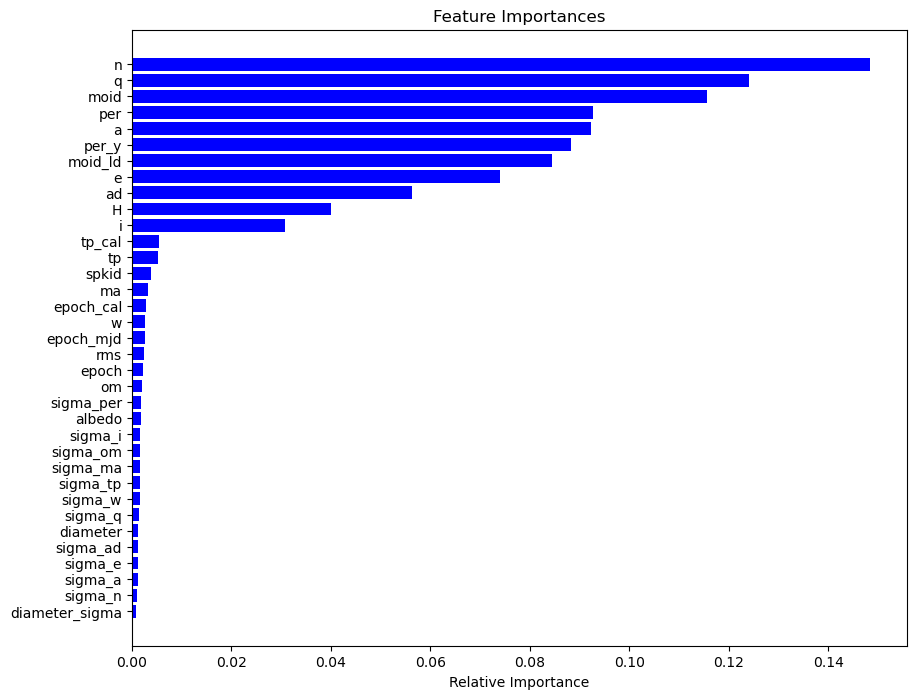

In [13]:
# Compute and print feature importances
feature_importances = etc.feature_importances_

# Create a dictionary to hold feature names and their importance values
features = X_train.columns
feature_importance_dict = dict(zip(features, feature_importances))

# Print feature importances along with their names
print("Feature importances:")
for feature, importance in feature_importance_dict.items():
    print(f"{feature}: {importance:.5f}")

# Visualize the feature importance
plt.figure(figsize=(10, 8))
indices = np.argsort(feature_importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Selection of Importance Features

In [14]:
threshold = np.mean(feature_importances)  # Define your threshold here

# Selecting features with importance greater than the threshold
selected_features = [feature for feature, importance in zip(X_train.columns, feature_importances) if importance > threshold]

print("Selected features:", selected_features)

Selected features: ['H', 'e', 'a', 'q', 'i', 'ad', 'n', 'per', 'per_y', 'moid', 'moid_ld']


In [15]:
# Include 'class' in selected features
selected_features.append('class')

# Filter the original Dask DataFrame to include only selected features
astro_ds_filtered = astro_ds[selected_features]

In [16]:
astro_ds_filtered.isnull().sum().compute()

H           6263
e              0
a              0
q              0
i              0
ad             4
n              0
per            4
per_y          1
moid       19921
moid_ld      127
class          0
dtype: int64

In [17]:
# Prepare features for imputation (excluding the target 'class')
X = astro_ds_filtered.drop(['class'], axis=1)
y = astro_ds_filtered['class']

In [18]:
# Applying SimpleImputer from Dask-ML to handle missing values in parallel
imputer = SimpleImputer(strategy='median')

# Since Dask works with lazy evaluation, use compute() to perform the computation
X_imputed = imputer.fit_transform(X)

In [19]:
# Ensure that imputation and other transformations are computed efficiently
with ProgressBar():
    X_imputed = X_imputed.compute()  # This will trigger the actual computation
    y = y.compute()  # Ensure the target variable is also ready for model training

[########################################] | 100% Completed | 933.98 ms
[########################################] | 100% Completed | 907.78 ms


In [20]:
y.unique()

array(['MBA', 'OMB', 'MCA', 'AMO', 'IMB', 'TJN', 'CEN', 'APO', 'ATE',
       'AST', 'TNO', 'IEO', 'HYA'], dtype=object)

### Test Train Split

In [21]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2,shuffle=True, random_state=42)

In [22]:
type(X_train),type(X_test),type(y_train),type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

#### Scaling and Encoding

In [23]:
# Scaling the data using Dask-ML's StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [25]:
type(X_train_scaled),type(X_test_scaled),type(y_train_encoded),type(y_test_encoded)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [26]:
X_train_scaled.shape,X_test_scaled.shape,y_train_encoded.shape,y_test_encoded.shape

((766819, 11), (191705, 11), (766819,), (191705,))

In [27]:
# If these are pandas DataFrame, convert them to Dask DataFrame
#X_train, y_train, X_test, y_test = dd.from_pandas(X_train), dd.from_pandas(y_train), dd.from_pandas(X_test), dd.from_pandas(y_test)

In [28]:
X_train.shape

(766819, 11)

## KNN

#### Parameter Grid

In [29]:
# Setup hyperparameter grid
param_grid_knn = {
    'n_neighbors': [3, 5],
    'weights': ['uniform', 'distance'],
    'p': [1]  # 1=Manhattan Distance, 2=Euclidean Distance
}

# # Setup hyperparameter grid
# param_grid_knn = {
#     'n_neighbors': [3, 5, 7, 10],
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2]  # 1=Manhattan Distance, 2=Euclidean Distance
# }

### Running KNN on multiple CPUs
- **Using Dask Client and Joblib for parallelization**

In [30]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
def run_knn_with_different_cpus(X_train_scaled, y_train, X_test_scaled, y_test, param_grid, cpu_configs):
    results = {}
    X_train_dask = da.from_array(X_train_scaled, chunks=(20000, X_train_scaled.shape[1]))
    X_test_dask = da.from_array(X_test_scaled, chunks=(20000, X_test_scaled.shape[1]))

    for cpus in cpu_configs:
        print(f"KNN for {cpus} CPUs\n")
        
        # Set up the KNN model with grid search
        knn = KNeighborsClassifier()
        grid_search_knn = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy')

        # Execute the grid search
        with tqdm(total=100) as pbar:
            start_time = time.time()
            with joblib.parallel_backend('multiprocessing',n_jobs=cpus):
                grid_search_knn.fit(X_train_dask, y_train)
            end_time = time.time()
            pbar.update(100)  # Update progress after finishing the job

        # Time taken
        time_taken_knn = end_time - start_time
        print(f"Time taken for hyperparameter tuning of KNN: {time_taken_knn:.2f} seconds")

        # Best parameters and accuracy
        best_params = grid_search_knn.best_params_
        best_score = grid_search_knn.best_score_
        best_knn = grid_search_knn.best_estimator_
        predictions_knn = best_knn.predict(X_test_dask)
        accuracy_knn = accuracy_score(y_test, predictions_knn)

        # Store results
        results[cpus] = {
            'Time Taken': end_time - start_time,
            'Best Parameters': grid_search_knn.best_params_,
            'Best Score': grid_search_knn.best_score_,
            'Best Estimator': best_knn,
            'Test Accuracy': accuracy_knn,
            'Predictions': predictions_knn
        }
        
    # Plotting the results
    cpus_list = list(results.keys())
    training_times = [results[cpus]['Time Taken'] for cpus in cpus_list]
    accuracies = [results[cpus]['Test Accuracy'] for cpus in cpus_list]

    plt.figure(figsize=(10, 5))
    plt.plot(cpus_list, training_times, marker='o', color='b')
    plt.title('Training Time Across Different CPU Configurations for KNN')
    plt.xlabel('Number of CPUs')
    plt.ylabel('Training Time (seconds)')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(cpus_list, accuracies, marker='o', color='r')
    plt.title('Accuracy Across Different CPU Configurations for KNN')
    plt.xlabel('Number of CPUs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    return results

KNN for 4 CPUs



100%|██████████| 100/100 [03:10<00:00,  1.90s/it]


Time taken for hyperparameter tuning of KNN: 190.30 seconds
KNN for 8 CPUs



100%|██████████| 100/100 [03:09<00:00,  1.89s/it]


Time taken for hyperparameter tuning of KNN: 189.04 seconds
KNN for 16 CPUs



100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


Time taken for hyperparameter tuning of KNN: 188.50 seconds
KNN for 20 CPUs



100%|██████████| 100/100 [03:09<00:00,  1.90s/it]


Time taken for hyperparameter tuning of KNN: 189.50 seconds


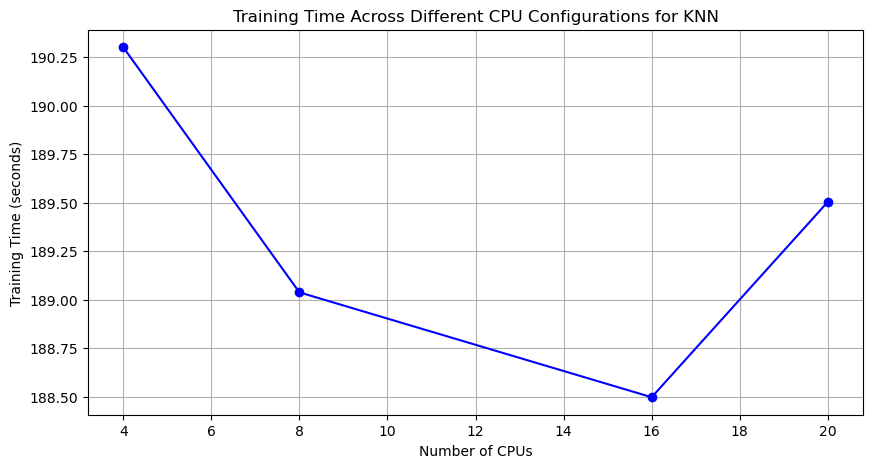

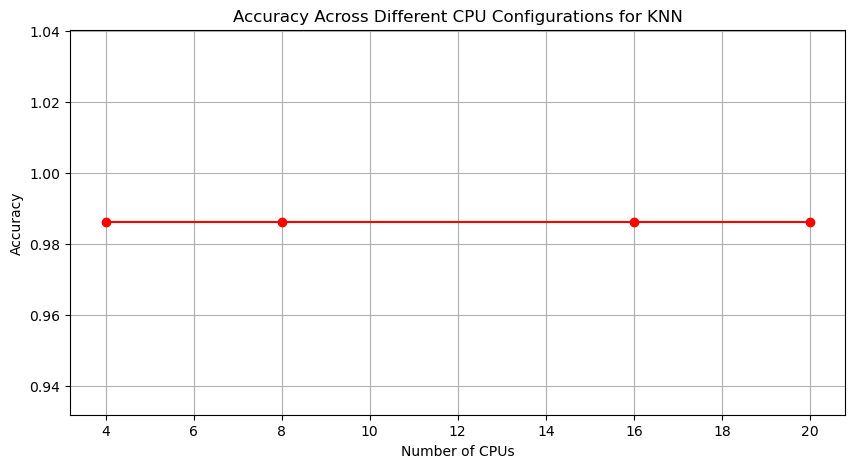

Total time taken for KNN on multiple CPUs:809.5266354084015seconds


In [31]:
start=time.time()
cpu_configs = [4,8,16,20]
results = run_knn_with_different_cpus(X_train_scaled, y_train, X_test_scaled, y_test, param_grid_knn, cpu_configs)
end=time.time()
print(f"Total time taken for KNN on multiple CPUs:{end-start}seconds")

### Further Evaluation and Visualization

Best parameters found for KNN:  {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best accuracy achieved by KNN:  0.985532439858689
Accuracy on Test Set by KNN:  0.9862131921441799
KNN Classification Report:
               precision    recall  f1-score   support

         AMO       0.90      0.92      0.91      1745
         APO       0.96      0.95      0.96      2540
         AST       0.45      0.50      0.48        10
         ATE       0.98      0.98      0.98       333
         CEN       0.93      0.91      0.92       108
         HYA       0.00      0.00      0.00         1
         IEO       1.00      0.50      0.67         4
         IMB       0.97      0.99      0.98      4035
         MBA       0.99      1.00      0.99    171100
         MCA       0.94      0.92      0.93      3795
         OMB       0.93      0.74      0.82      5731
         TJN       1.00      1.00      1.00      1619
         TNO       1.00      0.99      1.00       684

    accuracy                     

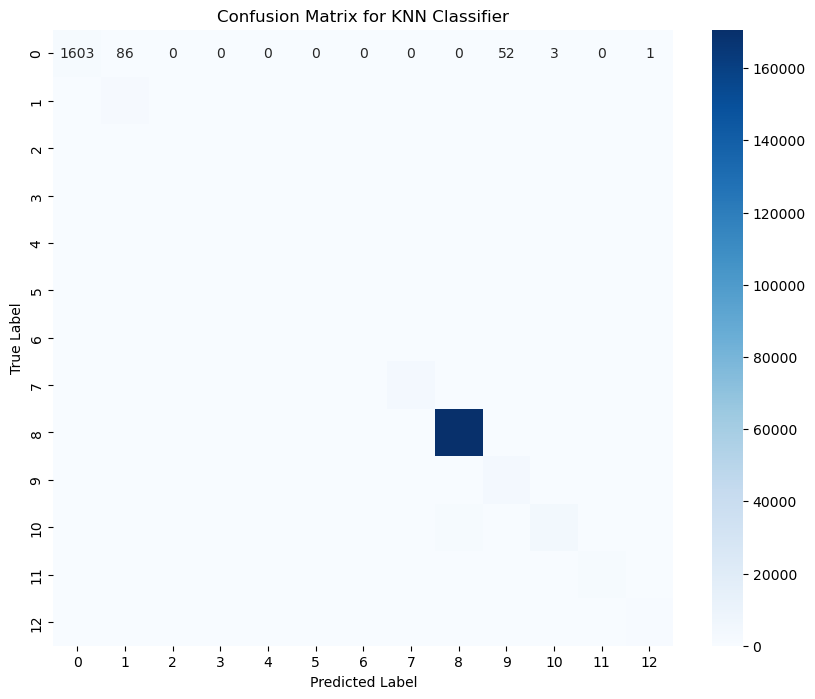

In [32]:
# Select a specific CPU configuration to analyze
cpu_to_analyze = 16

# Best model from the results
best_knn = results[cpu_to_analyze]['Best Estimator']
predictions_knn = results[cpu_to_analyze]['Predictions']

# Print best parameters and best score
print("Best parameters found for KNN: ", results[cpu_to_analyze]['Best Parameters'])
print("Best accuracy achieved by KNN: ", results[cpu_to_analyze]['Best Score'])
print("Accuracy on Test Set by KNN: ", results[cpu_to_analyze]['Test Accuracy'])
print("KNN Classification Report:\n", classification_report(y_test, predictions_knn))

# Confusion Matrix
conf_matrix_knn = confusion_matrix(y_test, predictions_knn)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN Classifier')
plt.show()